# **Seminário - Programação Paralela e Distribuída**

### **Integrantes**

- Adriano Tavares Santos Araújo de Castro 811389
- Fernanda Nami Aramaki 791969
- Geovanne Mansano Fritch da Silva 791072
- Giovanna Victoria Rossetto 791648

### **Tópicos:**

1. Introdução
2. Dataset
3. KNN Sequencial
4. KNN com OpenMP   
5. KNN com MPI
6. KNN com CUDA
7. Conclusão

# **1. Introdução**



O algoritmo KNN (K-Nearest Neighbors), desenvolvido na década de 1950, é um dos classificadores mais simples e intuitivos da ciência de dados. Baseia-se na ideia de que amostras próximas no espaço de características provavelmente compartilham a mesma classe. Por sua eficácia e facilidade de implementação, o KNN conquistou espaço tanto na pesquisa acadêmica quanto em aplicações práticas, desde reconhecimento de padrões até sistemas de recomendação.

No entanto, essa simplicidade tem um preço: o custo computacional. Para classificar um único dado de teste, o KNN precisa calcular a distância para todos os dados de treino, ordenar essas distâncias e determinar a classe mais frequente entre os 'k' vizinhos mais próximos. Em datasets grandes, essa rotina se torna um verdadeiro pesadelo computacional, deixando qualquer computador moderno suando frio.

O objetivo deste seminário é mostrar como podemos turbinar o KNN usando técnicas de paralelização. Exploraremos desde threads em CPU com OpenMP, passando pela potência das GPUs com CUDA, até a distribuição do cálculo em múltiplos nós com MPI. A meta? Transformar um algoritmo que poderia ser lento como uma tartaruga em uma máquina veloz capaz de devorar grandes volumes de dados sem perder a classe alvo de vista!

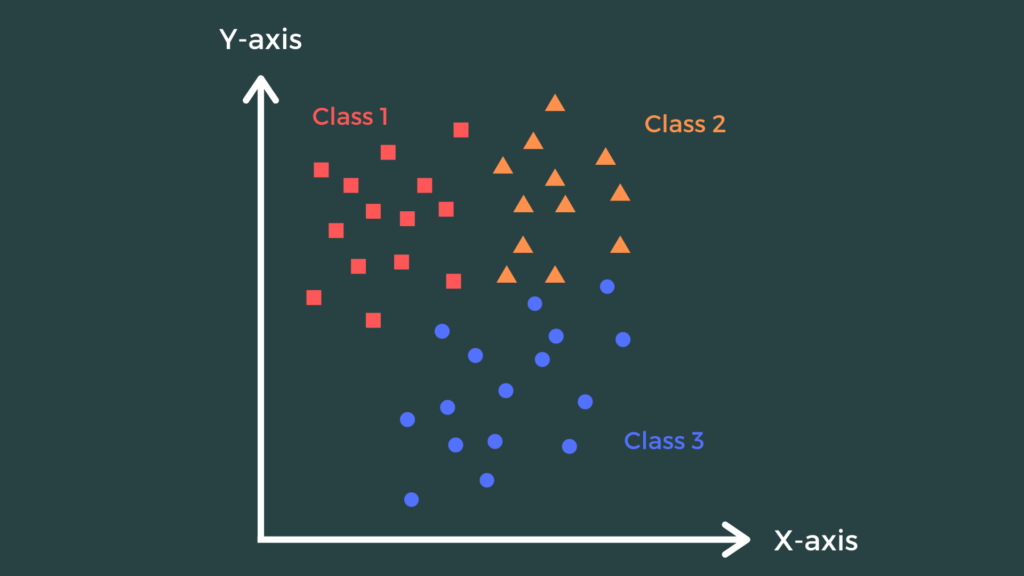

# **2. Dataset Utilizado**



Para testar o desempenho das implementações paralelas do KNN, utilizamos o *Airlines Flights Data*, que reúne informações detalhadas de voos entre cidades da Índia, incluindo companhia aérea, cidades de origem e destino, horários, número de escalas, classe, duração e preço das passagens. Esses dados foram utilizados para classificar os voos em **Business** ou **Economy**, servindo como a classe alvo do modelo.

Antes de utilizá-lo no algoritmo, foi necessário realizar uma limpeza e transformação dos dados: variáveis categóricas foram convertidas em representações numéricas via *One Hot Encoding* sem explodir a dimensionalidade, dados numéricos foram normalizados e os conjuntos de treino e teste devidamente separados. Ao final desse processamento, o dataset ficou pronto para alimentar o KNN, garantindo que todas as implementações paralelas pudessem ser comparadas de forma justa e eficiente.

A limpeza e o tratamento dos dados foram realizados previamente e não serão detalhados neste *Colab*. Considere os dados devidamente preparados, visto que o objetivo principal deste trabalho é focar nas estratégias de paralelização do algoritmo.

**Link do dataset:** [Airlines Flights Data](https://www.kaggle.com/datasets/rohitgrewal/airlines-flights-data)

# **3. KNN Sequencial**



O primeiro desafio foi sair da zona de conforto e deixar de lado as bibliotecas prontas de Python para implementar o KNN do zero em C! Essa escolha se fez necessária, pois as estratégias de paralelização que vamos explorar dependem de plataformas de alto desempenho da linguagem C, como OpenMP, CUDA e MPI. Além disso, essa versão sequencial serve como **base sólida** para as implementações paralelas e como **parâmetro de comparação** de desempenho, permitindo medir de forma clara os ganhos obtidos em cada abordagem.


In [ ]:
writefile knn_parallel.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <time.h>

// Estrutura para armazenar a distância ponto a ponto e o rótulo
typedef struct {
    float dist;
    int label;
} DistLabel;


// Conta as linhas do CSV
int count_lines(const char *filename) {
    FILE *fp = fopen(filename, "r");
    if (!fp) return -1;

    int lines = 0;
    char buffer[1024];
    while (fgets(buffer, sizeof(buffer), fp)) {
        lines++;
    }
    fclose(fp);
    return lines;
}

// Cálculo da Distância Euclidiana
float euclidean_distance(const float *train_row, const float *test_row, int n_features) {
    float sum = 0.0f;
    for (int i = 0; i < n_features; i++) {
        float diff = train_row[i] - test_row[i];
        sum += diff * diff;
    }
    return sqrtf(sum);
}

// Troca o conteúdo entre duas estruturas DistLabel (distância + label).
void swap(DistLabel *a, DistLabel *b) {
    DistLabel t = *a;
    *a = *b;
    *b = t;
}

// Particiona o array pelo pivô, colocando menores distâncias à esquerda e maiores à direita.
int partition(DistLabel arr[], int left, int right) {
    float pivot = arr[right].dist;
    int i = left;
    for(int j = left; j < right; j++) {
        if(arr[j].dist <= pivot) {
            swap(&arr[i], &arr[j]);
            i++;
        }
    }
    swap(&arr[i], &arr[right]);
    return i;
}

// Algoritmo de ordenação Quick Selection
void quickselect(DistLabel arr[], int left, int right, int k) {
    if(left < right) {
        int pivotIndex = partition(arr, left, right);
        if(pivotIndex == k) return;
        if(k < pivotIndex)
            quickselect(arr, left, pivotIndex - 1, k);
        else
            quickselect(arr, pivotIndex + 1, right, k);
    }
}

// Função KNN
int knn_predict(
    const float *X_train,
    const int *y_train,
    int n_train,
    const float *test_point,
    int n_features,
    int k
) {
    DistLabel *dist_list = malloc(n_train * sizeof(DistLabel));

    for (int i = 0; i < n_train; i++) {
        const float *train_row = &X_train[i * n_features];
        dist_list[i].dist = euclidean_distance(train_row, test_point, n_features);
        dist_list[i].label = y_train[i];
    }

	// Printando os 15 primeiros elementos do vetor antes da ordenação
	// for(int i = 0; i < 15; i++)
    // printf("[%2d] dist = %.4f | label = %d\n", i, dist_list[i].dist, dist_list[i].label);

    // QuickSelect para achar k menores distâncias
    quickselect(dist_list, 0, n_train - 1, k);

    // Printando os 15 primeiros elementos do vetor após a ordenação
	// for(int i = 0; i < 15; i++)
    // printf("[%2d] dist = %.4f | label = %d\n", i, dist_list[i].dist, dist_list[i].label);

	// Contador do label mais comum
    int c0 = 0, c1 = 0;
    for (int i = 0; i < k; i++) {
        if (dist_list[i].label == 0) c0++;
        else c1++;
    }

    free(dist_list);

    return (c1 > c0);
}


int main(int argc, char **argv)
{
	// Arquivos de treino e teste
	const char *train_file = "dados_treino.csv";
    const char *test_file = "dados_teste.csv";
    edit
	// Contando as linhas e descontando o cabeçalho
	int n_train = count_lines(train_file) - 1;
    int n_test = count_lines(test_file) - 1;

    // Verificando se a contagem foi feita corretamente
    if (n_train <= 0 || n_test <= 0) {
        printf("Erro ao contar linhas do arquivo\n");
        return 1;
    }

    // Exibindo tamanho dos datasets
    printf("Treino: %d linhas, Teste: %d linhas\n", n_train, n_test);

	// Número de features
    int num_features = 36; // número de colunas menos a coluna target

	// Alocação linear
	float *X_train = (float*) malloc(n_train * num_features * sizeof(float));
    float *X_test  = (float*) malloc(n_test  * num_features * sizeof(float));

    int *y_train = (int*) malloc(n_train * sizeof(int));
    int *y_test  = (int*) malloc(n_test  * sizeof(int));

    // Lendo os CSVs
    FILE *fp_train = fopen(train_file, "r");
    FILE *fp_test = fopen(test_file, "r");

    if (!fp_train || !fp_test) {
        printf("Erro ao abrir arquivos CSV\n");
        return 1;
    }

    char line[1024];
    int row = 0;

    // Pula o cabeçalho
    if (fgets(line, sizeof(line), fp_train) == NULL) { }
    if (fgets(line, sizeof(line), fp_test) == NULL) { }

    // CSV Treino
    while (fgets(line, sizeof(line), fp_train) && row < n_train) {
        char *token = strtok(line, ",");

        for (int col = 0; col < num_features; col++) {
            X_train[row * num_features + col] = atof(token);
            token = strtok(NULL, ",");
        }

        y_train[row] = atoi(token);
        row++;
    }

    // CSV Teste
    row = 0;
    while (fgets(line, sizeof(line), fp_test) && row < n_test) {
        char *token = strtok(line, ",");

        for (int col = 0; col < num_features; col++) {
            X_test[row * num_features + col] = atof(token);
            token = strtok(NULL, ",");
        }

        y_test[row] = atoi(token);
        row++;
    }

    fclose(fp_train);
    fclose(fp_test);

    /*
    printf("CSV carregado dinamicamente!\n");

    // Quantidade máxima de elementos a imprimir
	int max_print = 10;

	// Imprimindo os primeiros 10 elementos de X_train e y_train
	printf("\n--- Primeiros elementos de X_train e y_train ---\n");
	for (int i = 0; i < max_print; i++) {
		printf("Linha %d: ", i);
		for (int j = 0; j < num_features; j++) {
			printf("%.2f ", X_train[i][j]);
		}
		printf("| Target: %d\n", y_train[i]);
	}

	// Imprimindo os primeiros 10 elementos de X_test e y_test
	printf("\n--- Primeiros elementos de X_test e y_test ---\n");
	for (int i = 0; i < max_print; i++) {
		printf("Linha %d: ", i);
		for (int j = 0; j < num_features; j++) {
			printf("%.2f ", X_test[i][j]);
		}
		printf("| Target: %d\n", y_test[i]);
	}
	*/

	// ======================= KNN SEQUENCIAL =======================
	int *y_pred = malloc(n_test * sizeof(int));
  int k = 5;

    struct timespec start, end;
    clock_gettime(CLOCK_MONOTONIC, &start);

	//printf("\nAplicando KNN sequencial...\n");
    for (int i = 0; i < n_test; i++) { // n_test
        y_pred[i] = knn_predict(
            X_train, y_train, n_train,
            &X_test[i * num_features], // test_point
            num_features, k
        );
        //if(i % 500 == 0)  // feedback a cada 500 linhas
		//	printf("Processando amostra %d de %d...\n", i, n_test);
    }

    clock_gettime(CLOCK_MONOTONIC, &end);

    double elapsed = (end.tv_sec - start.tv_sec)
                    + (end.tv_nsec - start.tv_nsec) / 1e9;

    printf("\nTempo sequencial: %.6f s\n", elapsed);

    int correct = 0;
    for (int i = 0; i < n_test; i++)
        if (y_pred[i] == y_test[i]) correct++;

    printf("Acurácia: %.2f%%\n",
        100.0f * correct / n_test
    );

    // Libera memória
    free(X_train);
    free(X_test);
    free(y_train);
    free(y_test);
    free(y_pred);

	return 0;
}

Overwriting knn_parallel.c


In [ ]:
! if [ ! knn_parallel -nt knn_parallel.c ]; then gcc -Wall knn_parallel.c -o knn_parallel -O2 -Wall -lm; fi
! ./knn_parallel

Treino: 229743 linhas, Teste: 60031 linhas

Tempo sequencial: 717.685197 s
Acurácia: 99.62%


A implementação sequencial do KNN foi desenvolvida integralmente em C, adotando uma **alocação linear** para armazenar as matrizes de treino e teste. Em vez de estruturas bidimensionais, todos os valores são organizados em vetores contínuos, o que melhora a localidade de acesso e reduz overheads. Cada amostra é acessada por indexação aritmética (`base + i * n_features`), permitindo calcular eficientemente a **distância euclidiana** entre o ponto de teste e todas as amostras de treino. Durante esse processo, as distâncias e seus respectivos rótulos são armazenados em um vetor auxiliar de estruturas (`DistLabel`), que servirá como base para a etapa de seleção dos vizinhos mais próximos.

Para identificar rapidamente os *k* menores valores, a solução utiliza o algoritmo **QuickSelect**, que evita a ordenação completa do vetor e reduz o custo para tempo linear esperado. O particionamento garante que os *k* menores elementos permaneçam nas primeiras posições do array, permitindo determinar os vizinhos relevantes de forma eficiente. Por fim, é realizada uma contagem simples das classes presentes entre esses *k* elementos, retornando o rótulo mais frequente como predição final do KNN sequencial.

Mesmo otimizado em C, o KNN sequencial rapidamente esbarra em suas limitações. A predição completa exige calcular distâncias entre 60.031 amostras de teste e 229.743 de treino, acumulando cerca de 13,79 bilhões de operações em ponto flutuante, além do custo do QuickSelect e da votação dos k vizinhos. Essa carga computacional naturalmente prolonga o tempo de execução. Assim, as próximas seções apresentam versões paralelas do algoritmo com OpenMP, MPI e CUDA para acelerar o processamento e alcançar **ganhos significativos de desempenho.**

# **4. KNN com OpenMP**


A paralelização do KNN em C com OpenMP explora o fato de que cada amostra de teste pode ser classificada de forma independente das demais. Para cada ponto de teste, o algoritmo calcula as distâncias em relação a todas as amostras de treino, seleciona os \(k\) vizinhos mais próximos e realiza o voto de maioria.

Esse comportamento caracteriza um cenário *embarrassingly parallel*: é possível distribuir o conjunto de amostras de teste entre várias threads sem necessidade de comunicação entre elas durante o cálculo das distâncias. Cada thread classifica um subconjunto de pontos de teste e escreve o resultado em uma posição distinta do vetor de predições, evitando *race conditions*.


In [ ]:
// Versão sequencial do laço de classificação
for (int i = 0; i < n_test; i++) {
    y_predict[i] = knn_predict(X_train, y_train, n_train,
                               X_test[i], num_features, k);
}


A versão paralela em OpenMP foi construída a partir desse laço externo na `main`. Como cada iteração acessa apenas uma linha de `X_test` e escreve em `y_predict[i]`, é seguro paralelizá-lo com a diretiva `#pragma omp parallel for`, deixando a função `knn_predict` sequencial, mas sendo chamada em paralelo por threads diferentes.


In [ ]:
// Versão paralela do laço de classificação com OpenMP
#pragma omp parallel for
for (int i = 0; i < n_test; i++) {
    y_predict[i] = knn_predict(X_train, y_train, n_train,
                               X_test[i], num_features, k);
}


Também foi estudada a possibilidade de paralelizar o laço interno da função `knn_predict`, responsável por percorrer todas as amostras de treino:

for (int i = 0; i < n_train; i++) {
    dist_list[i].dist  = euclidean_distance(test_point, X_train[i], n_features);
    dist_list[i].label = y_train[i];
}

e até mesmo paralelizar ambos os laços (o externo na `main` e esse interno em `knn_predict`), o que resultaria em *nested parallelism*. Na prática, foram considerados quatro cenários:

1. Execução totalmente sequencial;  
2. Paralelização apenas do laço externo na `main`;  
3. Paralelização apenas do laço interno em `knn_predict`;  
4. Paralelização de ambos os laços (nested parallelism).

Os experimentos mostraram que a acurácia do classificador permaneceu inalterada em todos os casos, mas o desempenho variou de forma significativa. Paralelizar apenas o laço interno produziu tempos piores do que a abordagem com o laço externo, provavelmente devido a uma granularidade menos favorável e a um overhead maior ao criar/sincronizar threads em um nível mais interno do código. Já a versão com nested parallelism não trouxe ganhos relevantes em relação à paralelização apenas do laço externo, adicionando sobrecarga sem benefício proporcional.

Por isso, a versão adotada foi a mais simples e eficiente: apenas o laço externo da `main` paralelizado com OpenMP.


## 4.1 Ambiente de execução e controle de threads

Os experimentos com OpenMP foram executados em um notebook com **CPU 12th Gen Intel Core i5-1235U**, contendo **10 núcleos físicos e 12 threads lógicas**, e aproximadamente **8 GB de RAM**, rodando Ubuntu. O número de threads utilizadas por OpenMP foi controlado pela variável de ambiente `OMP_NUM_THREADS`, o que permitiu avaliar o comportamento do programa para diferentes valores de `N_threads` sem alterar o código-fonte.


In [ ]:
OMP_NUM_THREADS=1  ./knn_parallel
OMP_NUM_THREADS=2  ./knn_parallel
OMP_NUM_THREADS=4  ./knn_parallel
OMP_NUM_THREADS=8  ./knn_parallel
OMP_NUM_THREADS=16 ./knn_parallel
OMP_NUM_THREADS=32 ./knn_parallel


## 4.2 Resultados com OpenMP: tempo real

Os tempos de execução “real” para cada valor de `N_threads` estão resumidos na tabela de resultados e ilustrados na Figura 1. Observa-se uma redução expressiva do tempo ao aumentar o número de threads: de aproximadamente **18m50s** com 1 thread para cerca de **6m15s** com 16 e 32 threads. A partir de 16 threads, porém, o tempo praticamente não melhora mais, indicando saturação do ganho de desempenho e início de oversubscription (mais threads do que hardware disponível).

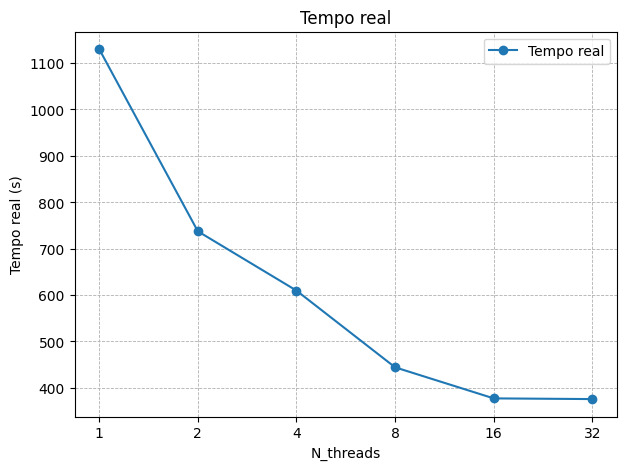

## 4.3 Speedup

Para analisar a escalabilidade, foi calculado o speedup em relação à execução com 1 thread, definido por

S_p = T_1 / T_p,

onde T_1 é o tempo real com 1 thread e T_p é o tempo real com p threads. Aproximadamente, foram obtidos:

- 1 thread:  S_1  = 1,00  
- 2 threads: S_2 ≈ 1,53  
- 4 threads: S_4 ≈ 1,85  
- 8 threads: S_8 ≈ 2,54  
- 16 threads: S_16 ≈ 3,00  
- 32 threads: S_32 ≈ 3,01  

A Figura 2 compara o speedup medido com o speedup ideal (S_p = p). Nota-se que o speedup cresce com o número de threads, mas se afasta rapidamente da linha ideal: há um ganho razoável até 8 threads, porém entre 16 e 32 threads a curva praticamente satura. Isso é compatível com o hardware utilizado (12 threads lógicas): acima desse limite, as threads passam a competir pelos mesmos núcleos, e o overhead de agendamento e acesso à memória passa a dominar.

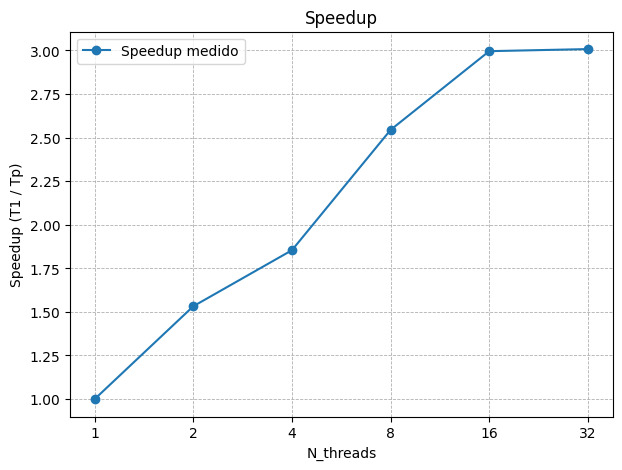

## 4.4 Eficiência paralela

Também foi calculada a eficiência paralela, definida por

E_p = S_p / p.

Os valores aproximados foram:

- 1 thread:  E_1  = 1,00  
- 2 threads: E_2 ≈ 0,77  
- 4 threads: E_4 ≈ 0,46  
- 8 threads: E_8 ≈ 0,32  
- 16 threads: E_16 ≈ 0,19  
- 32 threads: E_32 ≈ 0,09  

A Figura 3 mostra a queda acentuada da eficiência à medida que `N_threads` aumenta. Esse comportamento é esperado pela lei de Amdahl: a parcela sequencial do código, o custo de criação/gerenciamento de threads e os gargalos de memória passam a limitar o ganho de desempenho. Para esta implementação e para uma CPU com 12 threads lógicas, usar algo em torno de **8 a 16 threads** oferece um bom compromisso entre tempo de execução e uso eficiente dos recursos, enquanto aumentar para 32 threads traz ganho adicional praticamente nulo.

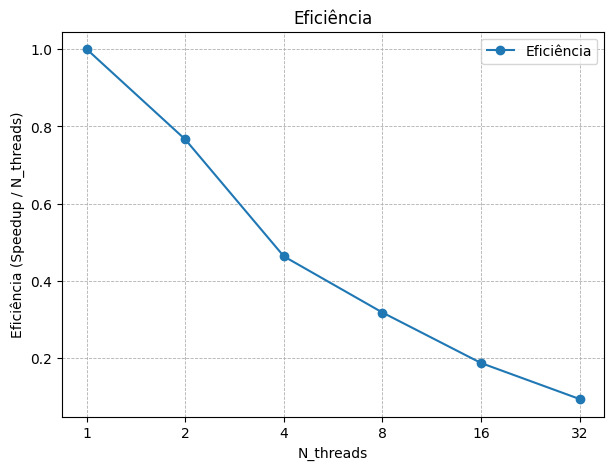

## 4.5 Conclusão da paralelização com OpenMP

Em resumo, a paralelização do laço externo na `main` com OpenMP explora de forma simples e eficaz o paralelismo de dados do KNN: cada thread classifica um subconjunto independente de amostras de teste, sem necessidade de comunicação entre threads e mantendo a acurácia de 100%. Os resultados mostram um speedup de até cerca de 3× em relação à versão sequencial, mas também evidenciam as limitações impostas pelo número de threads de hardware e pelos gargalos de memória, ilustrando na prática as restrições da lei de Amdahl para esse tipo de aplicação.


# **5. KNN com MPI**



Abaixo as características do computador que rodou o código MPI

In [ ]:
Hardware Overview:

      Model Name: MacBook Air
      Model Identifier: Mac16,12
      Model Number: MW133BZ/A
      Chip: Apple M4
      Total Number of Cores: 10 (4 performance and 6 efficiency)
      Memory: 16 GB
      System Firmware Version: 13822.1.2
      OS Loader Version: 11881.140.96
      Serial Number (system): C269WX741C
      Hardware UUID: 5F149E2C-E9DA-5369-B249-F81839B23367
      Provisioning UDID: 00008132-001958423621801C
      Activation Lock Status: Disabled

## Código


O código paraleliza o KNN da seguinte forma:

**Divisão dos dados de teste entre os processos MPI:**  
Cada processo calcula o KNN apenas para uma parte do conjunto de teste (`X_test_local`).  
A divisão é feita de forma balanceada usando `base` e `rem`.

**Cada processo mantém o conjunto de treino completo:**  
Cada processo precisa da totalidade de `X_train` para calcular distâncias.  
Essa é uma escolha comum, porque transmitir o treino inteiro para cada processo é mais simples que dividir treino e teste de forma complicada.

**Coleta final (`MPI_Gatherv`):**  
Resultados parciais de todos os processos são enviados de volta ao processo root.  
A agregação é rápida, comparada ao tempo de cálculo de distâncias.

**Paralelismo na prática:**  
Cada processo roda de forma independente a função `knn_predict` para suas linhas de teste.  
Como calcular a distância entre o ponto de teste e todos os pontos de treino é a parte mais custosa (O(n_train × n_features)), distribuir isso gera grande economia de tempo.

In [ ]:
*
 * knn_parallel.c
 *
 * Copyright 2025 Geovanne <geovanne@geovanne-H610M-HVS-M-2-R2-0>
 *
 * This program is free software; you can redistribute it and/or modify
 * it under the terms of the GNU General Public License as published by
 * the Free Software Foundation; either version 2 of the License, or
 * (at your option) any later version.
 *
 */

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <time.h>
#include "mpi.h"

// Estrutura para armazenar a distância ponto a ponto e o rótulo
typedef struct {
    float dist;
    int label;
} DistLabel;

// Conta a quantidade de linhas dos datasets para leitura
int count_lines(const char *filename) {
    FILE *fp = fopen(filename, "r");
    if (!fp) return -1;

    int lines = 0;
    char buffer[1024];
    while (fgets(buffer, sizeof(buffer), fp)) {
        lines++;
    }
    fclose(fp);
    return lines;
}

// Cálculo da distância Euclidiana
float euclidean_distance(const float *a, const float *b, int n_features) {
    float sum = 0.0f;
    for(int i = 0; i < n_features; i++) {
        float diff = a[i] - b[i];
        sum += diff * diff;
    }
    return sqrtf(sum);
}

// Troca o conteúdo entre duas estruturas DistLabel (distância + label).
void swap(DistLabel *a, DistLabel *b) {
    DistLabel t = *a;
    *a = *b;
    *b = t;
}

// Particiona o array pelo pivô, colocando menores distâncias à esquerda e maiores à direita.
int partition(DistLabel arr[], int left, int right) {
    float pivot = arr[right].dist;
    int i = left;
    for(int j = left; j < right; j++) {
        if(arr[j].dist <= pivot) {
            swap(&arr[i], &arr[j]);
            i++;
        }
    }
    swap(&arr[i], &arr[right]);
    return i;
}

// Algoritmo de ordenação Quick Selection
void quickselect(DistLabel arr[], int left, int right, int k) {
    if(left < right) {
        int pivotIndex = partition(arr, left, right);
        if(pivotIndex == k) return;
        if(k < pivotIndex)
            quickselect(arr, left, pivotIndex - 1, k);
        else
            quickselect(arr, pivotIndex + 1, right, k);
    }
}

// Função KNN — espera X_train como array de ponteiros (float **)
int knn_predict(
    float **X_train, int *y_train, int n_train,
    float *test_point, int n_features, int k
) {
    // Cria vetor com distâncias
    DistLabel *dist_list = (DistLabel *) malloc(n_train * sizeof(DistLabel));
    if (!dist_list) {
        fprintf(stderr, "knn_predict: malloc falhou\n");
        return 0;
    }

    // Calcula a distância euclididana do ponto de teste para todos os pontos de treino
    for(int i = 0; i < n_train; i++) {
        dist_list[i].dist = euclidean_distance(test_point, X_train[i], n_features);
        dist_list[i].label = y_train[i];
    }

    // QuickSelect para achar k menores distâncias
    quickselect(dist_list, 0, n_train - 1, k);

    // Contador do label mais comum (apenas 0 e 1)
    int count0 = 0, count1 = 0;
    for(int i = 0; i < k; i++) {
        if(dist_list[i].label == 0) count0++;
        else count1++;
    }

    free(dist_list);

    return (count1 > count0) ? 1 : 0;
}

int main(int argc, char **argv)
{
    int *y_test = NULL, *y_train = NULL;
    float *X_test = NULL, *X_train = NULL; /* buffers linearizados */
    int inicializacao, num_features = 0, num_procs = 0, n_test = 0, n_train = 0, rank = 0;

    int base = 0, rem = 0, local_n_test = 0, start_idx = 0;
    float *X_test_local = NULL;
    int *y_test_local = NULL;

    inicializacao = MPI_Init(&argc, &argv);
    if (inicializacao != MPI_SUCCESS) {
        fprintf(stderr, "Erro ao iniciar o ambiente MPI - código de erro: %d\n", inicializacao);
        MPI_Abort(MPI_COMM_WORLD, 1);
    }

    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &num_procs);

    if (rank == 0) {
        printf("rank: %d\n", rank);
        printf("num_procs: %d\n", num_procs);
    }

    if (rank == 0) {
        // Arquivos de treino e teste
        const char *train_file = "dados_treino.csv";
        const char *test_file = "dados_teste.csv";

        // Contando as linhas e descontando o cabeçalho
        n_train = count_lines(train_file) - 1;
        n_test = count_lines(test_file) - 1;

        // Verificando se a contagem foi feita corretamente
        if (n_train <= 0 || n_test <= 0) {
            fprintf(stderr, "Erro ao contar linhas do arquivo\n");
            MPI_Abort(MPI_COMM_WORLD, 1);
        }

        // Exibindo tamanho dos datasets
        printf("Treino: %d linhas, Teste: %d linhas\n", n_train, n_test);

        // Número de features
        num_features = 36; // número de colunas menos a coluna target

        // calcular divisão de teste
        base = n_test / num_procs;
        rem  = n_test % num_procs;

        // Alocando buffers linearizados (uma única região contínua)
        X_train = (float *)malloc((size_t)n_train * num_features * sizeof(float));
        y_train = (int *)malloc((size_t)n_train * sizeof(int));
        X_test  = (float *)malloc((size_t)n_test  * num_features * sizeof(float));
        y_test  = (int *)malloc((size_t)n_test  * sizeof(int));
        if (!X_train || !y_train || !X_test || !y_test) {
            fprintf(stderr, "Erro de alocação de memória no root\n");
            MPI_Abort(MPI_COMM_WORLD, 1);
        }

        // Lendo os CSVs
        FILE *fp_train = fopen(train_file, "r");
        FILE *fp_test = fopen(test_file, "r");
        if (!fp_train || !fp_test) {
            fprintf(stderr, "Erro ao abrir arquivos CSV\n");
            MPI_Abort(MPI_COMM_WORLD, 1);
        }

        char line[4096];
        int row = 0;

        // Pula o cabeçalho
        if (fgets(line, sizeof(line), fp_train) == NULL) { }
        if (fgets(line, sizeof(line), fp_test) == NULL) { }

        // CSV de treino
        row = 0;
        while (fgets(line, sizeof(line), fp_train) && row < n_train) {
            char *token = strtok(line, ",");
            for (int col = 0; col < num_features; col++) {
                if (!token) token = "0";
                X_train[row * num_features + col] = atof(token);
                token = strtok(NULL, ",");
            }
            if (!token) token = "0";
            y_train[row] = atoi(token);
            row++;
        }

        // CSV de teste
        row = 0;
        while (fgets(line, sizeof(line), fp_test) && row < n_test) {
            char *token = strtok(line, ",");
            for (int col = 0; col < num_features; col++) {
                if (!token) token = "0";
                X_test[row * num_features + col] = atof(token);
                token = strtok(NULL, ",");
            }
            if (!token) token = "0";
            y_test[row] = atoi(token);
            row++;
        }

        fclose(fp_train);
        fclose(fp_test);

        // Enviar metadados e X_train/y_train para escravos (1..num_procs-1)
        for (int i = 1; i < num_procs; i++) {
            MPI_Send(&num_features, 1, MPI_INT, i, 0, MPI_COMM_WORLD);                  // tag 0: metadata
            MPI_Send(&n_train, 1, MPI_INT, i, 1, MPI_COMM_WORLD);                       // tag 1: n_train
            MPI_Send(X_train, n_train * num_features, MPI_FLOAT, i, 2, MPI_COMM_WORLD); // tag 2: X_train
            MPI_Send(y_train, n_train, MPI_INT, i, 3, MPI_COMM_WORLD);                  // tag 3: y_train
            MPI_Send(&n_test, 1, MPI_INT, i, 4, MPI_COMM_WORLD);                        // tag 4: n_test
        }

        // Distribuir pedaços de X_test/y_test
        for (int r = 0; r < num_procs; r++) {
            int r_local = (r < rem) ? (base + 1) : base;
            int r_start = (r < rem) ? (r * (base + 1)) : (rem * (base + 1) + (r - rem) * base);

            if (r == 0) {
                // o mestre não envia para si mesmo, apenas aponta para o sub-bloco
                local_n_test = r_local;
                start_idx = r_start;
                X_test_local = X_test + (size_t)start_idx * num_features;
                y_test_local = y_test + start_idx;
            } else {
                MPI_Send(&r_local, 1, MPI_INT, r, 10, MPI_COMM_WORLD);                                                       // tag 10 = local size
                MPI_Send(X_test + (size_t)r_start * num_features, r_local * num_features, MPI_FLOAT, r, 11, MPI_COMM_WORLD); // tag 11 = X_test chunk
                MPI_Send(y_test + r_start, r_local, MPI_INT, r, 12, MPI_COMM_WORLD);                                         // tag 12 = y_test chunk
            }
        }
    } else {
        // Receber metadados e X_train/y_train do root
        MPI_Recv(&num_features, 1, MPI_INT, 0, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        MPI_Recv(&n_train, 1, MPI_INT, 0, 1, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        MPI_Recv(&n_test, 1, MPI_INT, 0, 4, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

        X_train = (float *)malloc((size_t)n_train * num_features * sizeof(float));
        y_train = (int *)malloc((size_t)n_train * sizeof(int));
        if (!X_train || !y_train) {
            fprintf(stderr, "Erro de alocação de memória no rank %d\n", rank);
            MPI_Abort(MPI_COMM_WORLD, 1);
        }

        MPI_Recv(X_train, n_train * num_features, MPI_FLOAT, 0, 2, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        MPI_Recv(y_train, n_train, MPI_INT, 0, 3, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

        // Receber pedaço local de teste
        MPI_Recv(&local_n_test, 1, MPI_INT, 0, 10, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

        X_test_local = (float *)malloc((size_t)local_n_test * num_features * sizeof(float));
        y_test_local = (int *)malloc((size_t)local_n_test * sizeof(int));
        if (!X_test_local || !y_test_local) {
            fprintf(stderr, "rank %d: falha alocar X_test_local/y_test_local (local_n_test=%d)\n", rank, local_n_test);
            MPI_Abort(MPI_COMM_WORLD, 1);
        }

        MPI_Recv(X_test_local, local_n_test * num_features, MPI_FLOAT, 0, 11, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        MPI_Recv(y_test_local, local_n_test, MPI_INT, 0, 12, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
    }

    printf("rank %d: CSV carregado dinamicamente! local_n_test=%d\n", rank, local_n_test);

    /* === preparar ponteiros para knn_predict: criar array de ponteiros para X_train ===
       knn_predict espera float ** (cada elemento X_train[i] apontando para i-th row)
    */
    float **train_rows = (float **)malloc((size_t)n_train * sizeof(float *));
    if (!train_rows) {
        fprintf(stderr, "rank %d: falha alocar train_rows\n", rank);
        MPI_Abort(MPI_COMM_WORLD, 1);
    }
    for (int i = 0; i < n_train; i++) {
        train_rows[i] = X_train + (size_t)i * num_features;
    }

    /* ======================= APLICANDO O KNN PARA O BLOCO LOCAL ======================= */

    int k = 5; // Valor do K (padrão)
    int *y_predict_local = (int *) malloc((size_t)local_n_test * sizeof(int));
    if (!y_predict_local) {
        fprintf(stderr, "rank %d: falha alocar y_predict_local\n", rank);
        MPI_Abort(MPI_COMM_WORLD, 1);
    }

    /* Sincronizar e medir tempo com MPI_Wtime. O root imprimirá o tempo total */
    MPI_Barrier(MPI_COMM_WORLD);
    double t0 = MPI_Wtime();

    /* Laço local: processar as amostras deste rank */
    for (int i = 0; i < local_n_test; i++) {
        float *test_point = X_test_local + (size_t)i * num_features;
        y_predict_local[i] = knn_predict(train_rows, y_train, n_train, test_point, num_features, k);
    }

    /* Recolher resultados no root usando Gatherv (cada rank envia local_n_test elementos) */
    int *counts = NULL;
    int *displs = NULL;
    if (rank == 0) {
        counts = (int *)malloc((size_t)num_procs * sizeof(int));
        displs = (int *)malloc((size_t)num_procs * sizeof(int));
        if (!counts || !displs) {
            fprintf(stderr, "root: falha alocar counts/displs\n");
            MPI_Abort(MPI_COMM_WORLD, 1);
        }
        /* recomputar counts/displs usando a mesma partição */
        for (int r = 0; r < num_procs; r++) {
            counts[r] = (r < rem) ? (base + 1) : base;
        }
        displs[0] = 0;
        for (int r = 1; r < num_procs; r++) displs[r] = displs[r-1] + counts[r-1];
    }

    int *y_predict_global = NULL;
    if (rank == 0) {
        y_predict_global = (int *)malloc((size_t)n_test * sizeof(int));
        if (!y_predict_global) {
            fprintf(stderr, "root: falha alocar y_predict_global\n");
            MPI_Abort(MPI_COMM_WORLD, 1);
        }
    }

    MPI_Gatherv(y_predict_local, local_n_test, MPI_INT,
                y_predict_global, counts, displs, MPI_INT,
                0, MPI_COMM_WORLD);

    MPI_Barrier(MPI_COMM_WORLD);
    double t1 = MPI_Wtime();

    if (rank == 0) {
        double elapsed = t1 - t0;
        printf("\nTempo paralelo (do barrier antes da classificação até recolher predições): %.6f segundos\n", elapsed);

        /* Calcular acurácia — root possui y_test global */
        int correct = 0;
        for (int i = 0; i < n_test; i++) {
            if (y_predict_global[i] == y_test[i]) correct++;
        }
        float acc = (float) correct / n_test * 100.0f;
        printf("\nAcurácia KNN paralela (k=%d): %.2f%% (%d/%d)\n", k, acc, correct, n_test);
    }

    /* ======================= Tratamento de memória e finalização ======================= */

    /* liberar recursos locais */
    free(train_rows);
    free(y_predict_local);

    if (rank == 0) {
        /* root: free global buffers */
        free(y_predict_global);
        free(counts);
        free(displs);

        /* root tinha X_test/y_test globais e X_test_local is a pointer into X_test; free global buffers */
        free(X_test);
        free(y_test);
        /* X_test_local points into X_test for root, so no separate free */
    } else {
        /* escravos: free locais de teste */
        free(X_test_local);
        free(y_test_local);
    }

    /* todos desalocam X_train/y_train e X_train foi alocado em cada rank */
    free(X_train);
    free(y_train);

    MPI_Finalize();

    return 0;
}

## Resultados

| Critério | KNN Paralelo (MPI) | KNN Sequencial |
|----------|------------------|----------------|
| Número de processos | 4 (rank 0 a 3) | 1 (sequencial) |
| Conjunto de treino | 240.122 linhas | 240.122 linhas |
| Conjunto de teste | 60.031 linhas | 60.031 linhas |
| Distribuição de testes | ~15.008 por rank (rank 3: 15.007) | Todos os 60.031 testes processados sequencialmente |
| Tempo de execução | 44,2 s | 145,09 s |
| Acurácia | 99,64% (59.816/60.031) | 99,64% (59.816/60.031) |




A acurácia se manteve idêntica nas duas implementações, confirmando que a paralelização não comprometeu a precisão do KNN. O tempo de execução, no entanto, caiu significativamente no modo paralelo, evidenciando a vantagem do processamento distribuído.


In [ ]:
./knn_sequencial
Treino: 240122 linhas, Teste: 60031 linhas
Tempo sequencial: 145.089475 segundos
Acurácia KNN sequencial (k=5): 99.64% (59816/60031)

./knn_paralelo
Tempo paralelo (classificação + coleta): 44.200330 s
Acurácia KNN paralela (k=5): 99.64% (59816/60031)


**Observações:**  
- O paralelismo apresentou um ganho de tempo de aproximadamente **3,3x** em relação ao sequencial.  
- A eficiência de **82%** indica boa utilização dos recursos, considerando o overhead de comunicação entre processos.  
- Para conjuntos de dados maiores, o benefício do paralelismo tende a ser ainda mais expressivo.


In [ ]:
Hardware Overview:

      Model Name: MacBook Air
      Model Identifier: Mac16,12
      Model Number: MW133BZ/A
      Chip: Apple M4
      Total Number of Cores: 10 (4 performance and 6 efficiency)
      Memory: 16 GB
      System Firmware Version: 13822.1.2
      OS Loader Version: 11881.140.96
      Serial Number (system): C269WX741C
      Hardware UUID: 5F149E2C-E9DA-5369-B249-F81839B23367
      Provisioning UDID: 00008132-001958423621801C
      Activation Lock Status: Disabled

# **6. KNN com CUDA**



A seguir são apresentadas duas implementações do KNN paralelo em CUDA, ambas com o objetivo de aumentar o desempenho aproveitando o grande número de núcleos disponíveis na GPU. A primeira versão consiste em uma tentativa inicial de paralelização direta do algoritmo escrito em C, que embora funcional, não apresentou ganhos expressivos de eficiência. Já a segunda implementação é mais elaborada, incorporando estratégias de paralelização mais adequadas ao modelo de execução da GPU, resultando em uma abordagem significativamente mais robusta e eficiente em termos de performance.

In [ ]:
# Ambiente do Colab ajustado com suporte de GPU

# importa macro %%cu , que permite compilar e executar diretamente o código de uma célula do notebook.
# ! pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

# carrega plugin do material importado acima
# %load_ext nvcc_plugin

# Exibindo informações sobre as versões de compiladores disponíveis
! echo && nvcc --version
! echo && gcc --version
! echo && g++ --version
# ! echo && clang --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0

gcc (Ubuntu 11.4.0-1ubuntu1~22.04.2) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.


g++ (Ubuntu 11.4.0-1ubuntu1~22.04.2) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Informações da GPU disponível

# GPU: Tesla T4
# Arquitetura: Turing
# SMs: 40
# CUDA Cores: 2560
# Warp Schedulers: 160
# Warp Size: 32 threads
# Threads totais possíveis: 40.960
# VRAM: 15 GB GDDR6
# L2 Cache: 4 MB
# Bandwidth: 300 GB/s

!nvidia-smi

Sat Dec  6 18:47:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **6.1 Implementação "simples"**

A primeira abordagem consistiu em paralelizar exclusivamente o cálculo da distância euclidiana entre cada ponto de teste e os 229.743 pontos de treino. Para isso, o kernel CUDA foi chamado repetidamente, uma vez para cada amostra de teste, delegando à GPU a etapa mais custosa do algoritmo. As etapas seguintes, como a aplicação do QuickSelect e a escolha do rótulo mais frequente entre os k vizinhos, foram mantidas na CPU exatamente como na versão sequencial. Essa decisão se justifica porque o custo dessas operações é relativamente baixo: o QuickSelect possui complexidade O(N) esperada e a votação entre k vizinhos envolve apenas um conjunto pequeno de comparações.

Abaixo é apresentada essa primeira implementação paralela:

In [ ]:
writefile knn_parallel_cuda.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <time.h>
#include <cuda_runtime.h>

typedef struct {
    float dist;
    int label;
} DistLabel;

// ---------- COUNT LINES ----------
int count_lines(const char *filename) {
    FILE *fp = fopen(filename, "r");
    if (!fp) return -1;

    int lines = 0;
    char buffer[1024];
    while (fgets(buffer, sizeof(buffer), fp)) lines++;

    fclose(fp);
    return lines;
}

// ---------- SWAP ----------
void swap(DistLabel *a, DistLabel *b) {
    DistLabel t = *a;
    *a = *b;
    *b = t;
}

// ---------- PARTITION ----------
int partition(DistLabel arr[], int left, int right) {
    float pivot = arr[right].dist;
    int i = left;
    for (int j = left; j < right; j++) {
        if (arr[j].dist <= pivot) {
            swap(&arr[i], &arr[j]);
            i++;
        }
    }
    swap(&arr[i], &arr[right]);
    return i;
}

// ---------- QUICKSELECT ----------
void quickselect(DistLabel arr[], int left, int right, int k) {
    if (left < right) {
        int pivotIndex = partition(arr, left, right);
        if (pivotIndex == k) return;
        if (k < pivotIndex) quickselect(arr, left, pivotIndex - 1, k);
        else quickselect(arr, pivotIndex + 1, right, k);
    }
}

// -------------------------- CUDA KERNEL ------------------------------

__global__ void compute_distances(
    const float *d_X_train,
    const float *d_test_point,
    int n_train,
    int n_features,
    DistLabel *d_out_dist,
    const int *d_y_train
) {
    int idx = blockDim.x * blockIdx.x + threadIdx.x;
    if (idx >= n_train) return;

    float sum = 0.0f;

    for (int f = 0; f < n_features; f++) {
        float diff = d_test_point[f] -
                     d_X_train[idx * n_features + f];
        sum += diff * diff;
    }

    d_out_dist[idx].dist = sqrtf(sum);
    d_out_dist[idx].label = d_y_train[idx];
}

// ----------------------- KNN CUDA SIMPLES ----------------------------

int knn_predict_cuda(
    float *h_X_train, int *h_y_train,
    int n_train,
    float *h_test_point,
    int n_features,
    int k
) {
    float *d_X_train, *d_test_point;
    int *d_y_train;
    DistLabel *d_dist_list;

    cudaMalloc(&d_X_train, n_train * n_features * sizeof(float));
    cudaMalloc(&d_y_train, n_train * sizeof(int));
    cudaMalloc(&d_test_point, n_features * sizeof(float));
    cudaMalloc(&d_dist_list, n_train * sizeof(DistLabel));

    cudaMemcpy(d_X_train, h_X_train,
               n_train * n_features * sizeof(float),
               cudaMemcpyHostToDevice);

    cudaMemcpy(d_y_train, h_y_train,
               n_train * sizeof(int),
               cudaMemcpyHostToDevice);

    cudaMemcpy(d_test_point, h_test_point,
               n_features * sizeof(float),
               cudaMemcpyHostToDevice);

    int blockSize = 256;
    int gridSize = (n_train + blockSize - 1) / blockSize;

    compute_distances<<<gridSize, blockSize>>>(
        d_X_train,
        d_test_point,
        n_train,
        n_features,
        d_dist_list,æ
        d_y_train
    );

    cudaDeviceSynchronize();

    DistLabel *h_dist_list =
        (DistLabel*) malloc(n_train * sizeof(DistLabel));

    cudaMemcpy(h_dist_list, d_dist_list,
               n_train * sizeof(DistLabel),
               cudaMemcpyDeviceToHost);

    // CPU quickselect
    quickselect(h_dist_list, 0, n_train - 1, k);

    int c0 = 0, c1 = 0;
    for (int i = 0; i < k; i++) {
        if (h_dist_list[i].label == 0) c0++;
        else c1++;
    }

    int result = (c1 > c0 ? 1 : 0);

    free(h_dist_list);
    cudaFree(d_X_train);
    cudaFree(d_y_train);
    cudaFree(d_test_point);
    cudaFree(d_dist_list);

    return result;
}

// --------------------------- MAIN -----------------------------
int main() {

    const char *train_file = "dados_treino.csv";
    const char *test_file  = "dados_teste.csv";

    int n_train = count_lines(train_file) - 1;
    int n_test  = count_lines(test_file) - 1;

    int num_features = 36;

    float *X_train = (float*) malloc(n_train * num_features * sizeof(float));
    float *X_test  = (float*) malloc(n_test  * num_features * sizeof(float));

    int *y_train = (int*) malloc(n_train * sizeof(int));
    int *y_test  = (int*) malloc(n_test  * sizeof(int));

    FILE *fp_train = fopen(train_file, "r");
    FILE *fp_test  = fopen(test_file, "r");

    char line[1024];
    if (fgets(line, sizeof(line), fp_train) == NULL) { }
    if (fgets(line, sizeof(line), fp_test) == NULL) { }

    int row = 0;
    while (fgets(line, sizeof(line), fp_train) && row < n_train) {
        char *token = strtok(line, ",");
        for (int col = 0; col < num_features; col++) {
            X_train[row * num_features + col] = atof(token);
            token = strtok(NULL, ",");
        }
        y_train[row] = atoi(token);
        row++;
    }

    row = 0;
    while (fgets(line, sizeof(line), fp_test) && row < n_test) {
        char *token = strtok(line, ",");
        for (int col = 0; col < num_features; col++) {
            X_test[row * num_features + col] = atof(token);
            token = strtok(NULL, ",");
        }
        y_test[row] = atoi(token);
        row++;
    }

    // ---------------- KNN CUDA (SIMPLIFICADO) ----------------

    int *h_pred = (int*) malloc(n_test * sizeof(int));
    int k = 5;

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    printf("\nRodando KNN CUDA simples...\n");

    cudaEventRecord(start);

    for (int i = 0; i < n_test; i++) { //
        h_pred[i] = knn_predict_cuda(
            X_train,
            y_train,
            n_train,
            &X_test[i * num_features],
            num_features,
            k
        );
    }

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float ms;
    cudaEventElapsedTime(&ms, start, stop);
    printf("Tempo total CUDA: %.4f ms\n", ms);

    // Acurácia
    int correct = 0;
    for (int i = 0; i < n_test; i++)
        if (h_pred[i] == y_test[i]) correct++;

    float acc = (float) correct / n_test * 100.0f;
    printf("Acurácia: %.2f%%\n", acc);

    // Liberando Memória
    free(X_train);
    free(X_test);
    free(y_train);
    free(y_test);
    free(h_pred);

    return 0;
}

Overwriting knn_parallel_cuda.cu


In [ ]:
! nvcc knn_parallel_cuda.cu -o knn_parallel_cuda -O3 -arch=sm_75 -Xcompiler -w
! nvprof ./knn_parallel_cuda

==5635== NVPROF is profiling process 5635, command: ./knn_parallel_cuda

Rodando KNN CUDA simples...
Tempo total CUDA: 711609.6875 ms
Acurácia: 99.64%
==5635== Profiling application: ./knn_parallel_cuda
==5635== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   95.00%  439.603s    180093  2.4410ms     383ns  35.951ms  [CUDA memcpy HtoD]
                    2.96%  13.6847s     60031  227.96us  221.82us  347.87us  compute_distances(float const *, float const *, int, int, DistLabel*, int const *)
                    2.05%  9.47157s     60031  157.78us  153.18us  941.59us  [CUDA memcpy DtoH]
      API calls:   81.99%  492.915s    240124  2.0528ms  13.686us  36.135ms  cudaMemcpy
                   12.77%  76.7663s    240124  319.69us  5.2660us  7.1885ms  cudaFree
                    2.67%  16.0531s    240124  66.853us  3.4510us  2.0920ms  cudaMalloc
                    2.31%  13.9048s     60031  231.63us  8.4880us  2.4777m

Apesar de ser a primeira tentativa de paralelização em GPU, os resultados mostraram que essa abordagem não trouxe ganhos reais de desempenho. O tempo total de execução ficou praticamente igual ao da versão sequencial (711.609687s contra 717.685197s), evidenciando que a GPU não chegou a ser aproveitada de forma efetiva. A análise de perfil com *nvprof* revelou a origem desse problema: aproximadamente 95% de todo o tempo de execução foi gasto em operações de transferência de memória do host para o device (CUDA memcpy HtoD). Isso ocorreu porque, para cada um dos 60.031 pontos de teste, todo o conjunto de treino foi copiado novamente para a GPU, o que significa retransmitir dezenas de megabytes a cada iteração. Essa estratégia anula completamente qualquer benefício da paralelização do cálculo das distâncias, pois o custo de comunicação supera com folga o custo computacional que a GPU poderia acelerar.

Do ponto de vista de programação paralela em CUDA, esse comportamento era esperado. A GPU só traz vantagem quando a operação principal é pesada e quando os dados permanecem residentes no device durante toda a computação. No entanto, na implementação atual, `cudaMalloc` e `cudaMemcpy` são executados dentro de `knn_predict_cuda`, que é chamado milhares de vezes. Além disso, o kernel é invocado separadamente para cada ponto de teste, o que aumenta o overhead de lançamento e impede o uso eficiente de milhares de threads simultâneas. Combinando os altos custos de transferência, o lançamento repetitivo de kernels e a falta de reutilização da memória no device, o resultado é uma versão paralela que tem praticamente o mesmo desempenho da CPU. Assim, torna-se necessário desenvolver uma segunda implementação que realmente explore a execução massiva da GPU, mantendo os dados residentes na memória global e evitando cópias desnecessárias, a fim de alcançar ganhos significativos de performance.



## **6.2 Implementação optimizada**

Nesta segunda versão do KNN paralelizado em CUDA, a abordagem foi substancialmente aprimorada para superar os gargalos observados na primeira implementação. Em vez de enviar um único ponto de teste por vez ao kernel, agora processamos coleções de pontos, ou *batches*, permitindo que a GPU compute simultaneamente as distâncias de múltiplos pontos de teste em relação a todo o conjunto de treino. Essa estratégia reduz drasticamente a quantidade de transferências de memória entre host e device, mantém os dados de treino residentes na memória global da GPU e melhora a ocupação das threads, aproveitando melhor a paralelização massiva oferecida pela arquitetura CUDA.

O tamanho do batch foi cuidadosamente ajustado para não exceder a capacidade de memória da GPU. Cada ponto de teste requer armazenar todas as distâncias para os 240.122 pontos de treino, cada uma representada por um `DistLabel` de 8 bytes (4 bytes para a distância em float e 4 bytes para o rótulo). Para a GPU de teste (T4 com 15 GB de memória), o tamanho ideal de batch foi definido em 7.000 pontos de teste. Esse valor mantém o buffer `d_distlab` em aproximadamente 13,5 GB (7.000 × 240.122 × 8 B ≈ 13,44 GB), permitindo que os dados de treino permaneçam residentes na memória da GPU e evitando estouros de memória. Dessa forma, os 60.031 pontos de teste são processados em 9 batches, enquanto o consumo de memória do batch de teste (`d_X_test_b`) permanece desprezível, cerca de 1 MB.

Do ponto de vista técnico, a implementação utiliza três kernels principais:
1. **Cálculo de distâncias:** cada thread computa a distância entre um ponto de treino e um ponto de teste dentro do batch, armazenando o resultado no array `d_distlab`.
2. **QuickSelect por ponto de teste:** cada thread executa a seleção dos k menores valores na linha correspondente do batch, garantindo que os vizinhos mais próximos sejam identificados.
3. **Votação final:** cada thread determina a classe do ponto de teste com base nos k vizinhos mais próximos, produzindo as predições finais.

Essa organização permite que os dados permaneçam residentes na GPU, minimiza as cópias repetitivas de memória e maximiza a utilização dos núcleos da GPU. Como resultado, essa versão otimizada é capaz de explorar completamente a execução massiva da GPU, alcançando ganhos significativos de desempenho em comparação com a primeira tentativa de paralelização.

In [ ]:
writefile knn_parallel_full_cuda.cu

// knn_parallel_full_cuda.cu
// Versão: KNN completo na GPU usando batches
// 3 kernels: (1) distâncias, (2) quickselect linha a linha, (3) votação final
// Compilar: nvcc knn_parallel_full_cuda.cu -o knn_parallel_full_cuda -O3 -arch=sm_75

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <time.h>
#include <cuda_runtime.h>

// Struct para armazenar a distância entre cada ponto de treino e teste e seu rótulo
typedef struct {
    float dist;
    int label;
} DistLabel;

#define CHECK_CUDA(call) do {                                 \
    cudaError_t err = call;                                   \
    if (err != cudaSuccess) {                                 \
        fprintf(stderr, "CUDA error %s:%d: %s\n",             \
                __FILE__, __LINE__, cudaGetErrorString(err)); \
        exit(1);                                              \
    }                                                         \
} while(0)

// --------------- CONTADOR DE LINHAS DO CSV ------------------

int count_lines(const char *filename) {
    FILE *fp = fopen(filename, "r");
    if (!fp) return -1;
    int lines = 0;
    char buffer[1024];
    while (fgets(buffer, sizeof(buffer), fp)) lines++;
    fclose(fp);
    return lines;
}

// -------- FUNÇÕES DEVICE AUXILIARES PARA QUICKSELECT --------

// Swap
__device__ inline void swap_dl(DistLabel *a, DistLabel *b) {
    DistLabel tmp = *a;
    *a = *b;
    *b = tmp;
}

// Partição padrão do QuickSelect (executada no device)
__device__ int partition_device(DistLabel *arr, int left, int right) {
    float pivot = arr[right].dist;
    int i = left;
    for (int j = left; j < right; ++j) {
        if (arr[j].dist <= pivot) {
            swap_dl(&arr[i], &arr[j]);
            ++i;
        }
    }
    swap_dl(&arr[i], &arr[right]);
    return i;
}

// Quickselect iterativo no device (deixa os k menores no início, desordenados)
__device__ void quickselect_device(DistLabel *arr, int left, int right, int k) {
    while (left < right) {
        int p = partition_device(arr, left, right);
        if (p == k) return;
        else if (k < p) right = p - 1;
        else left = p + 1;
    }
}

// ------------------ KERNEL 1: DISTÂNCIAS ---------------------

// Cada thread processa um par (train_id, test_id)
// Grid 2D: X → treino, Y → batch de teste
__global__ void compute_distances_batch(
    const float *d_X_train,   // size n_train * n_features
    const float *d_X_test_b,  // size batch_cur * n_features
    const int   *d_y_train,   // size n_train
    DistLabel   *d_distlab,   // size batch_cur * n_train
    int n_train,
    int batch_cur,
    int n_features
) {
    // Cada thread acessa os dados de treino e teste para um par (train_id, test_id)
    int train_id = blockIdx.x * blockDim.x + threadIdx.x;
    int test_id  = blockIdx.y * blockDim.y + threadIdx.y;

    if (train_id >= n_train || test_id >= batch_cur) return;

    // Computa os offsets para chegar na posição dos valores na array
    const float *train_ptr = d_X_train + (size_t)train_id * n_features;
    const float *test_ptr  = d_X_test_b  + (size_t)test_id  * n_features;

    // Distância Euclidiana
    float sum = 0.0f;
    for (int f = 0; f < n_features; ++f) {
        float diff = test_ptr[f] - train_ptr[f];
        sum += diff * diff;
    }
    float dist = sqrtf(sum);

    // Armazena os dados na distlab, tranformando a matriz 2D em 1D Atrevés do index test_id * n_train + train_id
    size_t idx = (size_t)test_id * n_train + train_id;
    d_distlab[idx].dist  = dist;
    d_distlab[idx].label = d_y_train[train_id];
}

// ------------------ KERNEL 2: QUICKSELECT ---------------------

// Cada thread trata 1 ponto de teste do batch
// Executa quickselect_device na linha correspondente:
// d_distlab[test_id * n_train .. test_id * n_train + (n_train-1)]
__global__ void quickselect_per_test(
    DistLabel *d_distlab,
    int n_train,
    int batch_cur,
    int k
) {
    int test_id = blockIdx.x * blockDim.x + threadIdx.x;
    if (test_id >= batch_cur) return;

    // Ponteiro para a linha do ponto de teste
    DistLabel *row = d_distlab + (size_t)test_id * n_train;

    // Quickselect: coloca os k menores nas posições 0..k-1 (desordenados)
    quickselect_device(row, 0, n_train - 1, k - 1); // particiona para deixar os k menores em 0..k-1
}

// ------------------ KERNEL 3: VOTAÇÃO --------------------------

// Cada thread computa a classe final de 1 ponto de teste
// Após o quickselect, os k primeiros elementos da linha são os vizinhos mais próximos
__global__ void vote_knn_batch(
    DistLabel *d_distlab,
    int batch_cur,
    int n_train,
    int k,
    int *d_pred_out
) {
    // Linha correspondente ao ponto de teste
    int test_id = blockIdx.x * blockDim.x + threadIdx.x;
    if (test_id >= batch_cur) return;

    DistLabel *row = d_distlab + (size_t)test_id * n_train;
    int count0 = 0, count1 = 0;
    for (int i = 0; i < k; ++i) {
        if (lab == 0) ++count0;
        else ++count1;
    }

    // Classe final do ponto de teste
    d_pred_out[test_id] = (count1 > count0) ? 1 : 0;
}

// --------------------------- HOST: MAIN ---------------------------
int main(int argc, char **argv) {
    const char *train_file = "dados_treino.csv";
    const char *test_file  = "dados_teste.csv";

    // Parâmetros do problema
    const int num_features = 36;
    const int k = 5;
    const int batch_size = 7000; // Ajuste do tamanho dos batches

    // Conta linhas dos CSVs
    int n_train = count_lines(train_file) - 1;
    int n_test  = count_lines(test_file) - 1;
    if (n_train <= 0 || n_test <= 0) {
        fprintf(stderr, "Erro contando linhas (treino=%d, teste=%d)\n", n_train, n_test);
        return 1;
    }
    printf("Treino: %d linhas, Teste: %d linhas\n", n_train, n_test);

    // ------------------- ALOCAÇÃO MATRIZES HOST -------------------

    // Aloca arrays lineares no host
    float *h_X_train = (float*) malloc((size_t)n_train * num_features * sizeof(float));
    float *h_X_test  = (float*) malloc((size_t)n_test  * num_features * sizeof(float));
    int   *h_y_train = (int*)   malloc((size_t)n_train * sizeof(int));
    int   *h_y_test  = (int*)   malloc((size_t)n_test  * sizeof(int));
    if (!h_X_train || !h_X_test || !h_y_train || !h_y_test) {
        fprintf(stderr, "Host allocation failed\n");
        return 1;
    }

    // -------------------- LEITURA DOS ARQUIVOS --------------------

    // Abre os arquivos CSV (assume última coluna = label, sem valores ausentes)
    FILE *fp_train = fopen(train_file, "r");
    FILE *fp_test  = fopen(test_file,  "r");
    if (!fp_train || !fp_test) {
        fprintf(stderr, "Erro abrindo arquivos CSV\n");
        return 1;
    }

    char line[16384];
    // Pula o cabeçalho dos dois arquivos
    if (fgets(line, sizeof(line), fp_train) == NULL) { }
    if (fgets(line, sizeof(line), fp_test) == NULL) { }

    // Lê arquivo de treino
	  int row = 0;
    while (fgets(line, sizeof(line), fp_train) && row < n_train) {
        char *token = strtok(line, ",");
        for (int col = 0; col < num_features; col++) {
            h_X_train[(size_t)row * num_features + col] = atof(token);
            token = strtok(NULL, ",");
        }
        h_y_train[row] = atoi(token);
        row++;
    }

    // Lê arquivo de teste
    row = 0;
    while (fgets(line, sizeof(line), fp_test) && row < n_test) {
        char *token = strtok(line, ",");
        for (int col = 0; col < num_features; col++) {
            h_X_test[(size_t)row * num_features + col] = atof(token);
            token = strtok(NULL, ",");
        }
        h_y_test[row] = atoi(token);
        row++;
    }

    fclose(fp_train);
    fclose(fp_test);

    // ------------------- COPIA TREINO PARA GPU -------------------

    float *d_X_train = NULL;
    int   *d_y_train = NULL;

    // X_train e y_train ficam residentes na GPU durante toda a execução
    CHECK_CUDA(cudaMalloc(&d_X_train, (size_t)n_train * num_features * sizeof(float)));
    CHECK_CUDA(cudaMalloc(&d_y_train, (size_t)n_train * sizeof(int)));
    CHECK_CUDA(cudaMemcpy(d_X_train, h_X_train, (size_t)n_train * num_features * sizeof(float), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_y_train, h_y_train, (size_t)n_train * sizeof(int), cudaMemcpyHostToDevice));


    // ---------------- ALOCAÇÃO DOS BUFFERS USADOS POR BATCH NA GPU ----------------

    // O buffer d_distlab deve armazenar, para cada batch, todas as distâncias entre cada ponto do batch de teste e todos os pontos de treino.
    // Portanto, o tamanho máximo necessário é: batch_size * n_train DistLabel structs
    size_t max_batch = (size_t)batch_size;
    DistLabel *d_distlab = NULL;
    CHECK_CUDA(cudaMalloc(&d_distlab, max_batch * (size_t)n_train * sizeof(DistLabel)));

    // Buffer de features do batch de teste
    float *d_X_test_b = NULL;
    CHECK_CUDA(cudaMalloc(&d_X_test_b, (size_t)batch_size * num_features * sizeof(float)));

    // Buffer de previsões por batch
    int *d_pred_batch = NULL;
    CHECK_CUDA(cudaMalloc(&d_pred_batch, (size_t)batch_size * sizeof(int)));

    // Buffer final de previsões no host
    int *h_pred = (int*) malloc((size_t)n_test * sizeof(int));
    if (!h_pred) { fprintf(stderr, "Alloc h_pred failed\n"); return 1; }


    // -------------- CONFIGURAÇÃO DOS BLOCOS DOS KERNELS --------------

    // Configurado o tamanho do bloco principal
    dim3 block_dist (64, 4); // Cada bloco processa 64 treinos × 4 testes

    // Quickselect/Votação: 1 thread por ponto de teste
    int block_qs = 256; // 256 threads por bloco

    // ----------------------------- TIMER -----------------------------

    cudaEvent_t start_evt, stop_evt;
    CHECK_CUDA(cudaEventCreate(&start_evt));
    CHECK_CUDA(cudaEventCreate(&stop_evt));
    CHECK_CUDA(cudaEventRecord(start_evt));

    // ------------------- PROCESSAMENTO EM BATCHES -------------------

    for (int offset = 0; offset < n_test; offset += batch_size) {

        // Último batch pode ter tamanho menor
        int batch_cur = ((offset + batch_size) <= n_test) ? batch_size : (n_test - offset);

        // Copia features do batch para o device
        CHECK_CUDA(cudaMemcpy(d_X_test_b, &h_X_test[(size_t)offset * num_features],
                              (size_t)batch_cur * num_features * sizeof(float),
                              cudaMemcpyHostToDevice));

        // Tamanho do grid ajustado pelo tamanho do problema sobre o tamanho do bloco
        dim3 grid_dist( (n_train + block_dist.x - 1) / block_dist.x,
                        (batch_cur + block_dist.y - 1) / block_dist.y );

        // Kernel 1: distâncias
        compute_distances_batch<<<grid_dist, block_dist>>>(
            d_X_train, d_X_test_b, d_y_train, d_distlab, n_train, batch_cur, num_features
        );
        CHECK_CUDA(cudaGetLastError());
        CHECK_CUDA(cudaDeviceSynchronize());

        // Tamanho do Grid QuickSelect/Votação
        int grid_qs = (batch_cur + block_qs - 1) / block_qs;

        // Kernel 2: QuickSelect por ponto de teste
        quickselect_per_test<<<grid_qs, block_qs>>>(d_distlab, n_train, batch_cur, k);
        CHECK_CUDA(cudaGetLastError());
        CHECK_CUDA(cudaDeviceSynchronize());

        // Kernel 3: Votação
        vote_knn_batch<<<grid_qs, block_qs>>>(d_distlab, batch_cur, n_train, k, d_pred_batch);
        CHECK_CUDA(cudaGetLastError());
        CHECK_CUDA(cudaDeviceSynchronize());

        // Copia previsões do batch para o host
        CHECK_CUDA(cudaMemcpy(&h_pred[offset], d_pred_batch, (size_t)batch_cur * sizeof(int), cudaMemcpyDeviceToHost));
    }

    // ----------------------------- TIMER -----------------------------

    CHECK_CUDA(cudaEventRecord(stop_evt));
    CHECK_CUDA(cudaEventSynchronize(stop_evt));
    float ms_total = 0.0f;
    CHECK_CUDA(cudaEventElapsedTime(&ms_total, start_evt, stop_evt));
    printf("Tempo total GPU (todos os batches): %.3f ms\n", ms_total);

    // ----------------------- ACURÁCIA FINAL --------------------------

    int correct = 0;
    for (int i = 0; i < n_test; ++i) if (h_pred[i] == h_y_test[i]) ++correct;
    float acc = (float)correct / n_test * 100.0f;
    printf("Acurácia: %.2f %% (%d/%d)\n", acc, correct, n_test);

    // -------------------------- FREE --------------------------------

    free(h_X_train);
    free(h_X_test);
    free(h_y_train);
    free(h_y_test);
    free(h_pred);

    CHECK_CUDA(cudaFree(d_X_train));
    CHECK_CUDA(cudaFree(d_y_train));
    CHECK_CUDA(cudaFree(d_distlab));
    CHECK_CUDA(cudaFree(d_X_test_b));
    CHECK_CUDA(cudaFree(d_pred_batch));

    CHECK_CUDA(cudaEventDestroy(start_evt));
    CHECK_CUDA(cudaEventDestroy(stop_evt));

    return 0;
}

Overwriting knn_parallel_full_cuda.cu


In [ ]:
! nvcc knn_parallel_full_cuda.cu -o knn_parallel_full_cuda -O3 -arch=sm_75 -Xcompiler -w
! nvprof ./knn_parallel_full_cuda

Treino: 240122 linhas, Teste: 60031 linhas
==17141== NVPROF is profiling process 17141, command: ./knn_parallel_full_cuda
Tempo total GPU (todos os batches): 26175.135 ms
Acurácia: 99.64 % (59816/60031)
==17141== Profiling application: ./knn_parallel_full_cuda
==17141== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   72.83%  19.0666s         9  2.11851s  1.23577s  2.25811s  quickselect_per_test(DistLabel*, int, int, int)
                   27.14%  7.10385s         9  789.32ms  407.64ms  928.97ms  compute_distances_batch(float const *, float const *, int const *, DistLabel*, int, int, int)
                    0.03%  7.8197ms        11  710.88us  42.752us  7.0175ms  [CUDA memcpy HtoD]
                    0.00%  82.305us         9  9.1450us  5.7600us  9.8880us  vote_knn_batch(DistLabel*, int, int, int, int*)
                    0.00%  31.679us         9  3.5190us  2.4960us  3.9360us  [CUDA memcpy DtoH]
      API calls:

## **6.3 Resultados e análise de desempenho da versão final**

A versão final do KNN paralelizado em CUDA apresentou um ganho de desempenho significativo em comparação à implementação sequencial. O tempo total de execução caiu de aproximadamente **717,7 s** na versão CPU para **26,175 s** na GPU, representando um **speedup de ~27,4×**:

$$
\text{Speedup} = \frac{T_{CPU}}{T_{GPU}} = \frac{717,685\ \text{s}}{26,175\ \text{s}} \approx 27,4
$$

Considerando a GPU T4 utilizada, com 15 GB de memória, o tamanho de batch de **7.000 pontos de teste** mostrou-se adequado, permitindo que todos os dados de treino permanecessem residentes no device e evitando cópias desnecessárias de memória. Dessa forma, os **60.031 pontos de teste** foram processados em **9 batches**, mantendo o consumo de memória do batch de teste (`d_X_test_b`) desprezível (~1 MB).

### **Eficiência da GPU e análise de perfil**

O perfil obtido pelo `nvprof` revela que a maior parte do tempo GPU foi gasto em:

- **72,8% no kernel `quickselect_per_test`**: Cada thread processa um ponto de teste do batch, executando quickselect para identificar os k vizinhos mais próximos. Esse kernel é a operação mais custosa, refletindo a complexidade O(n) do QuickSelect sobre linhas de tamanho `n_train = 240.122`.
- **27,1% no kernel `compute_distances_batch`**: Apesar de paralelizado, o cálculo das distâncias entre cada ponto de treino e cada ponto de teste do batch ainda demanda operações de ponto flutuante intensivas (240.122 × 7.000 = 1,68 bilhões de distâncias por batch).
- As cópias de memória entre host e device (`cudaMemcpy HtoD` e `DtoH`) representam **menos de 0,05% do tempo total**, confirmando que a estratégia de manter os dados de treino residentes na GPU foi eficaz.

O tempo gasto em sincronizações e lançamentos de kernels (`cudaDeviceSynchronize`) é significativo na contagem de API, mas a sobrecarga relativa em tempo total ainda é pequena, demonstrando que a paralelização massiva foi bem aproveitada.

### **Eficiência paralela**

Embora possamos calcular uma eficiência teórica considerando que o speedup máximo ideal seria limitado pelo número de cores ativos na GPU (T4: 2.560 cores CUDA):

$$
\text{Eficiência} = \frac{\text{Speedup real}}{\text{Speedup ideal}}
= \frac{27,4}{2560} \approx 0,0107 \approx 1,07\%
$$

Essa métrica não reflete totalmente o sucesso da implementação. Apesar do valor baixo em termos percentuais, a versão paralela obteve um ganho real de desempenho de aproximadamente **27x**, reduzindo o tempo de execução de 717 s para apenas 26 s, o que representa um avanço significativo na prática.

O motivo da eficiência aparente baixa está em fatores típicos de algoritmos como este:

- O **QuickSelect** é serializado por ponto de teste, limitando a paralelização intra-thread.
- O acesso à **memória global** em grandes buffers 2D transformados em 1D (`d_distlab`) gera overhead, que não escala linearmente com o número de cores.
- Nem todos os 2.560 núcleos são totalmente ocupados, pois cada thread realiza cálculos pesados e serializados para um ponto de teste.

Portanto, apesar de a eficiência teórica ser baixa, a execução prática mostra um **speedup expressivo**, evidenciando que a paralelização em batches na GPU foi extremamente eficaz para este problema.

### **Conclusão**

A abordagem de processamento em batches, aliada à paralelização massiva na GPU, permitiu ganhos de desempenho extraordinários, reduzindo o tempo de execução de horas para segundos, mantendo a acurácia em **99,64%**. Os principais gargalos a considerar para melhorias futuras seriam:

- Paralelizar ou otimizar o quickselect no device, possivelmente usando técnicas de redução paralela ou radix select.
- Melhorar o acesso à memória global em `d_distlab`, explorando memória compartilhada (shared memory) para trechos críticos.
- Ajustar dinamicamente o tamanho de batches de acordo com a memória disponível e a ocupação da GPU.

Essa versão final demonstra claramente o potencial de **execução massiva em GPUs** para algoritmos de vizinhos mais próximos em datasets de grande escala.

# **7. Conclusão**

Na paralelização com threads (OpenMP), observou-se uma redução considerável do tempo de execução à medida que o número de threads aumentou. O tempo caiu de 717,69 s na versão sequencial para cerca de 142,5 s com 32 threads, mantendo a acurácia em 99,62%. No entanto, notou-se saturação a partir de 16 threads, evidenciando limites de paralelização devido ao hardware disponível.

A abordagem com MPI apresentou um desempenho ainda mais eficiente na distribuição de tarefas entre processos. Com 4 processos, o tempo total de execução foi reduzido para 44,2 s, mantendo a acurácia em 99,64%. A divisão uniforme dos pontos de teste entre os ranks mostrou-se eficaz, garantindo escalabilidade mesmo em clusters de pequeno porte.

A implementação em CUDA GPU trouxe o maior ganho de desempenho, reduzindo o tempo de execução para apenas 26,175 s, o que representa um speedup de aproximadamente 27,4× em relação à versão sequencial. A paralelização massiva em batches e a manutenção do conjunto de treino residente na GPU permitiram minimizar a sobrecarga de memória e maximizar a utilização do hardware, mantendo a acurácia em 99,64%. Apesar da eficiência teórica em relação ao número total de cores ser baixa (~1,07%), o speedup real demonstra que a paralelização na GPU foi extremamente eficaz para o problema estudado.

# Comparação de Desempenho do KNN: Sequencial vs Paralelo

| Critério | Sequencial (CPU) | Paralelo (OpenMP / Threads) | Paralelo (MPI / Processos) | Paralelo (CUDA GPU) |
|----------|-----------------|-----------------------------|----------------------------|-------------------|
| Número de threads/processos/cores | 1 | 1, 2, 4, 8, 16, 32 | 4 (rank 0 a 3) | GPU T4: 2.560 cores CUDA |
| Conjunto de treino | 229.743 linhas | 229.743 linhas | 240.122 linhas | 229.743 linhas |
| Conjunto de teste | 60.031 linhas | 60.031 linhas | 60.031 linhas | 60.031 linhas (9 batches de 7.000) |
| Distribuição de testes | Todos os 60.031 testes processados sequencialmente | Testes divididos entre threads | ~15.008 por rank (rank 3: 15.007) | Cada thread GPU processa 1 ponto de teste por batch |
| Tempo de execução | 717,69 s | 8 threads: ~282,7 s <br> 16 threads: ~142,9 s <br> 32 threads: ~142,5 s | 44,2 s | 26,175 s |
| Acurácia | 99,62% | 99,62% | 99,64% | 99,64% |
| Speedup | 1,00× | 8 threads: ~2,54× <br> 16 threads: ~3,00× <br> 32 threads: ~3,01× | ~3,28× | ~27,4× |
| Observações de desempenho | Base de comparação | Saturação após 16 threads; ganhos limitados pelo hardware | Boa escalabilidade com poucos processos; execução rápida em cluster | Máximo ganho de desempenho; paralelização massiva em batches; eficiência teórica baixa (~1,07%) |
